## Import libraries

In [73]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.model_selection import (
    KFold,
    GridSearchCV,
    cross_val_score,
    train_test_split,
)
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    f1_score,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score,
)

## Data Preparation

In [74]:
# Run the data preprocessing notebook
data = pd.read_csv("docs/Breast_Cancer_Dataset.csv")

In [75]:
data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [76]:
data.shape

(569, 33)

In [77]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [78]:
# Drop ID Column
data = data.drop(["id", "Unnamed: 32"], axis=1)

In [79]:
data["diagnosis"] = data["diagnosis"].map({"M": 1, "B": 0})
data["diagnosis"]

0      1
1      1
2      1
3      1
4      1
      ..
564    1
565    1
566    1
567    1
568    0
Name: diagnosis, Length: 569, dtype: int64

In [80]:
# Check if Duplicated
data.duplicated().value_counts()

False    569
Name: count, dtype: int64

In [81]:
# There are not Na's in the data
for column in data:
    print(data[column].isna().value_counts())
    print(" ")

diagnosis
False    569
Name: count, dtype: int64
 
radius_mean
False    569
Name: count, dtype: int64
 
texture_mean
False    569
Name: count, dtype: int64
 
perimeter_mean
False    569
Name: count, dtype: int64
 
area_mean
False    569
Name: count, dtype: int64
 
smoothness_mean
False    569
Name: count, dtype: int64
 
compactness_mean
False    569
Name: count, dtype: int64
 
concavity_mean
False    569
Name: count, dtype: int64
 
concave points_mean
False    569
Name: count, dtype: int64
 
symmetry_mean
False    569
Name: count, dtype: int64
 
fractal_dimension_mean
False    569
Name: count, dtype: int64
 
radius_se
False    569
Name: count, dtype: int64
 
texture_se
False    569
Name: count, dtype: int64
 
perimeter_se
False    569
Name: count, dtype: int64
 
area_se
False    569
Name: count, dtype: int64
 
smoothness_se
False    569
Name: count, dtype: int64
 
compactness_se
False    569
Name: count, dtype: int64
 
concavity_se
False    569
Name: count, dtype: int64
 
concave point

### Outliers

In [82]:
def handle_outliers_and_normalize(data, numerical_cols, target_col, strategy="keep"):
    """
    Detects outliers, plots the distribution of each numerical column, handles outliers based on the chosen strategy,
    and normalizes numerical variables while leaving the target column unchanged.

    Parameters:
    - data (pd.DataFrame): Input dataset.
    - numerical_cols (list): List of numerical columns to analyze.
    - target_col (str): Name of the target column that should NOT be modified.
    - strategy (str): Strategy to handle outliers.
        - "remove": Removes rows with outliers.
        - "median": Replaces outliers with the median of the column.
        - "mean": Replaces outliers with the mean of the column.
        - "keep": Leaves outliers as they are.

    Returns:
    - pd.DataFrame: Modified and normalized dataset with handled outliers.
    """
    # Create a copy of the original data to avoid modifying it
    data_copy = data.copy()
    outliers_info = {}

    for col in numerical_cols:
        # Calculate IQR (Interquartile Range)
        Q1 = data[col].quantile(0.25)  # 25th percentile
        Q3 = data[col].quantile(0.75)  # 75th percentile
        IQR = Q3 - Q1

        # Define lower and upper bounds for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Detect outliers
        outliers = data_copy[
            (data_copy[col] < lower_bound) | (data_copy[col] > upper_bound)
        ]
        num_outliers = len(outliers)
        outliers_info[col] = num_outliers

        # Plot boxplot and histogram for each column
        plt.figure(figsize=(10, 4))

        # Boxplot
        plt.subplot(1, 2, 1)
        plt.boxplot(data[col], vert=False)
        plt.title(f"Boxplot of {col}")

        # Histogram
        plt.subplot(1, 2, 2)
        plt.hist(data[col], bins=30, color="skyblue", edgecolor="black")
        plt.title(f"Distribution of {col}")

        plt.show()

        # Handle outliers based on the chosen strategy
        if strategy == "remove":
            # Remove rows with outliers
            data_copy = data_copy[
                (data_copy[col] >= lower_bound) & (data_copy[col] <= upper_bound)
            ]

        elif strategy == "median":
            # Replace outliers with the median
            median_value = data[col].median()
            data_copy.loc[data_copy[col] < lower_bound, col] = median_value
            data_copy.loc[data_copy[col] > upper_bound, col] = median_value

        elif strategy == "mean":
            # Replace outliers with the mean
            mean_value = data[col].mean()
            data_copy.loc[data_copy[col] < lower_bound, col] = mean_value
            data_copy.loc[data_copy[col] > upper_bound, col] = mean_value

        elif strategy == "keep":
            # Do nothing, keep the outliers
            pass

    # Drop any NaN rows caused by inconsistent index alignment
    if strategy == "remove":
        data_copy = data_copy.dropna().reset_index(drop=True)

    print("\nSummary of detected outliers per column:")
    for col, count in outliers_info.items():
        print(f"- {col}: {count} outliers detected")

    # Separate features and target to prevent normalizing the target column
    features = data_copy[numerical_cols]
    target = data_copy[target_col].reset_index(drop=True)

    # Normalize numerical variables (excluding target column)
    scaler = StandardScaler().set_output(transform="pandas")
    normalized_features = scaler.fit_transform(features)

    # Combine normalized features with the target column
    normalized_data = pd.concat([normalized_features, target], axis=1)

    print(
        "\nNumerical variables successfully normalized while keeping the target column unchanged."
    )

    return normalized_data

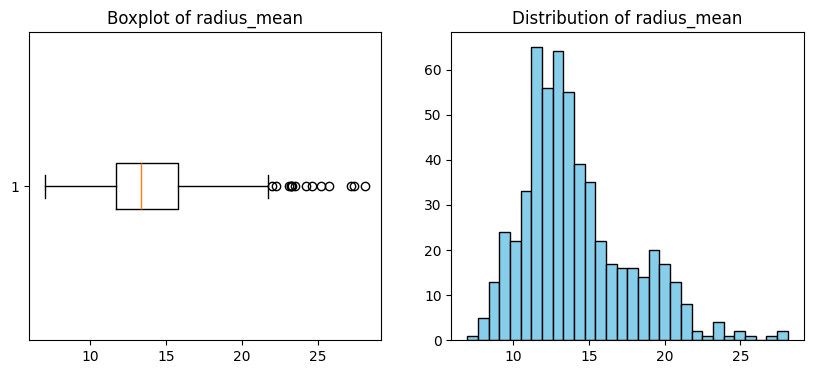

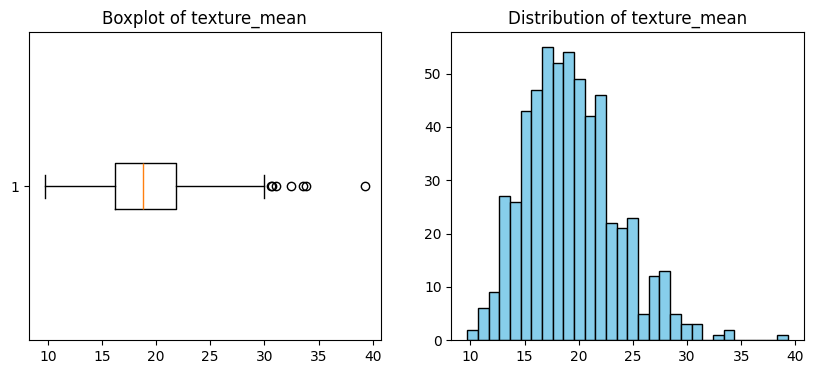

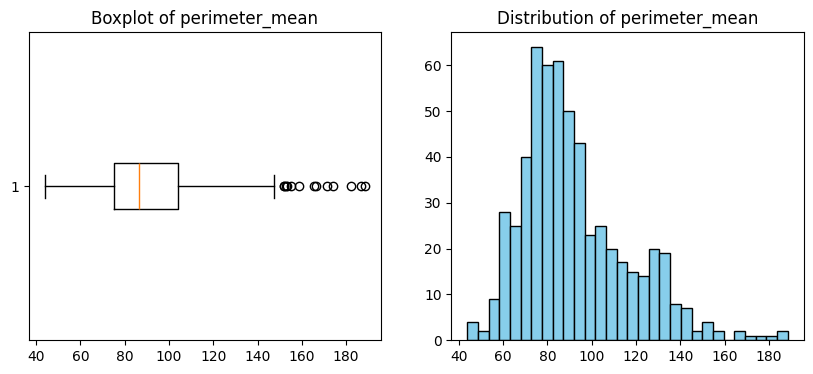

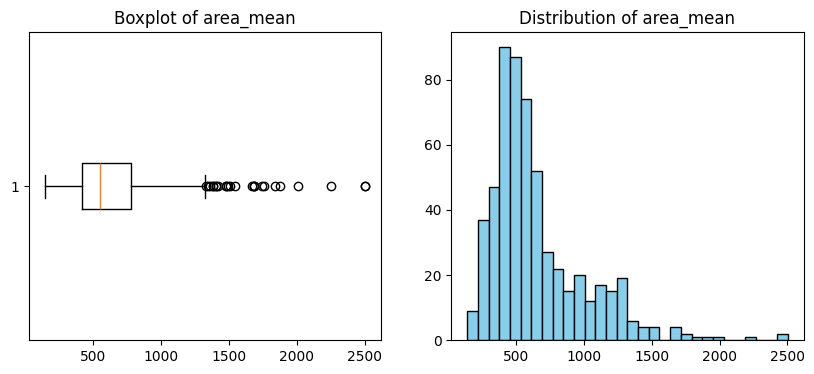

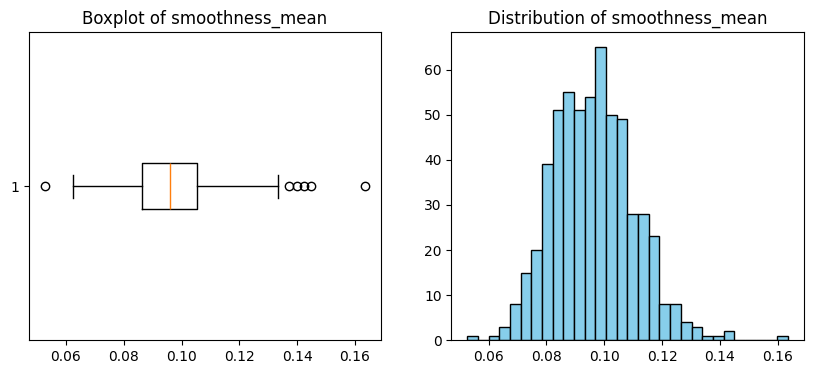

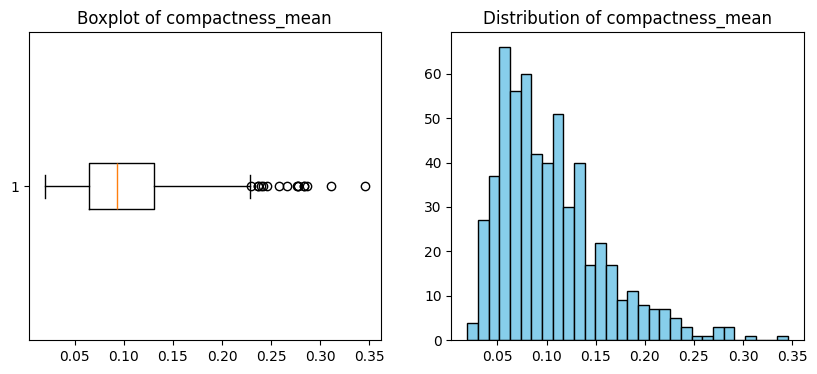

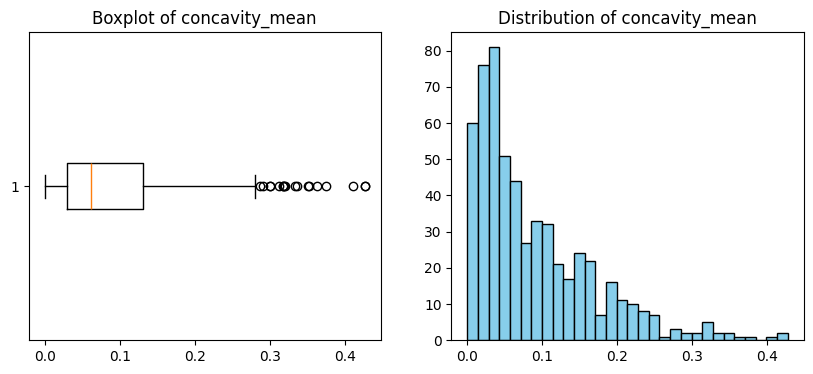

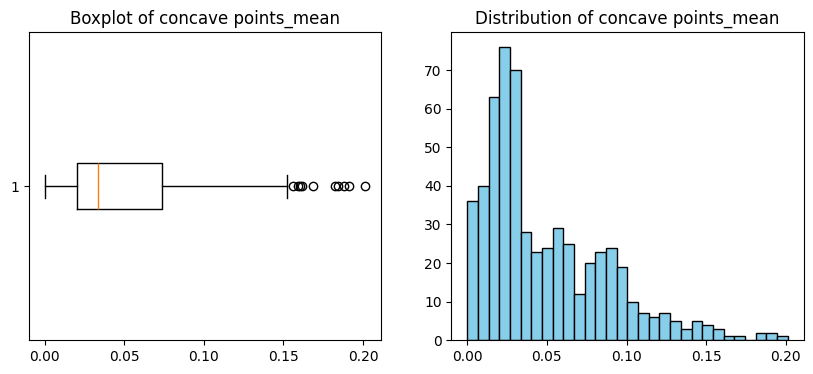

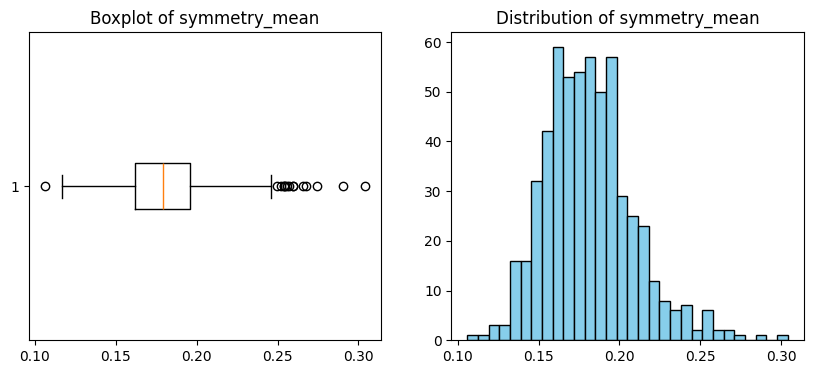

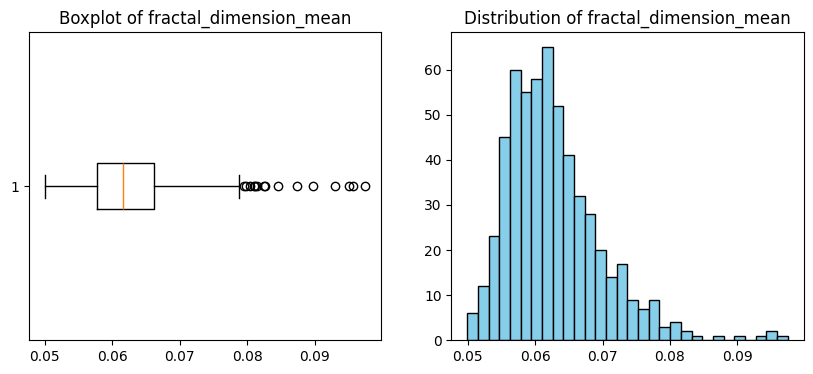

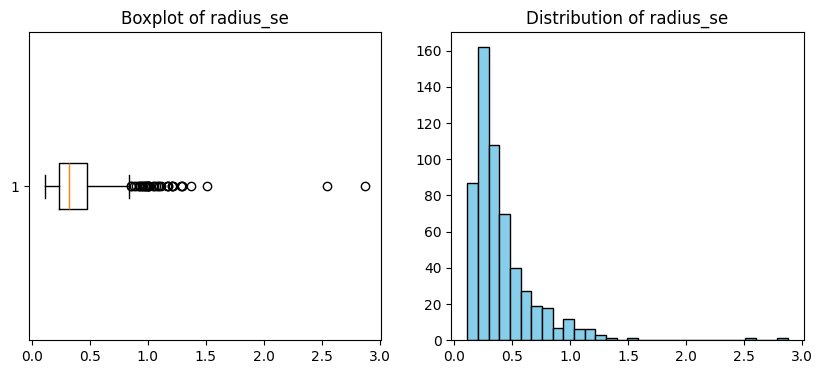

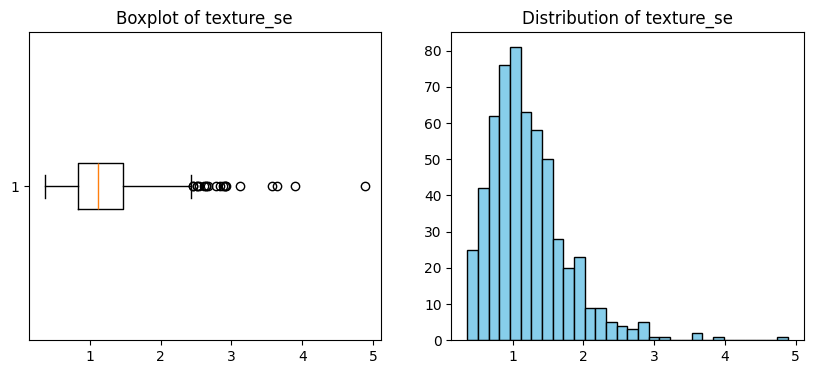

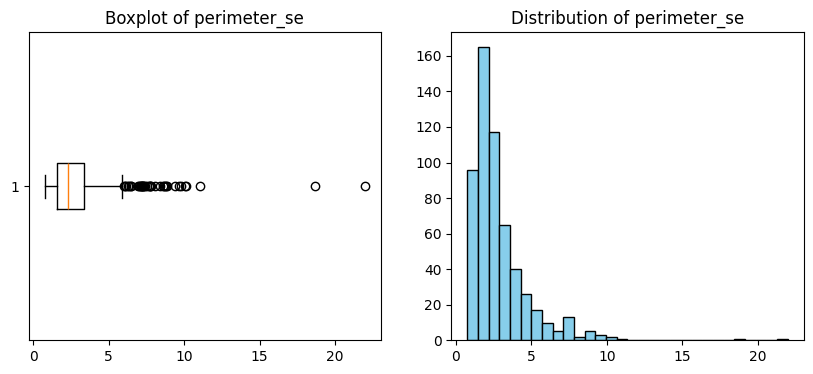

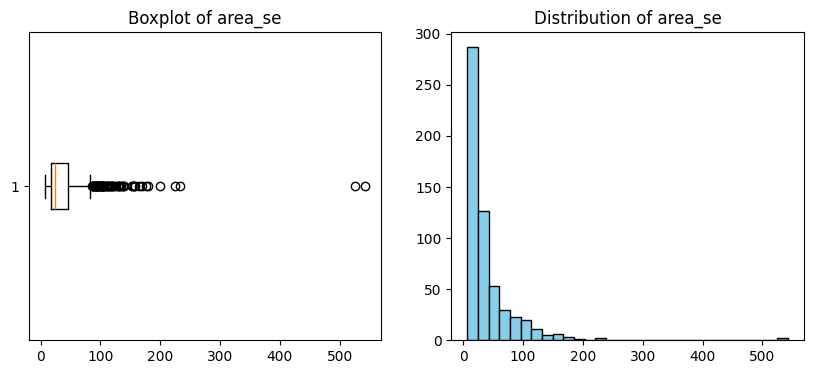

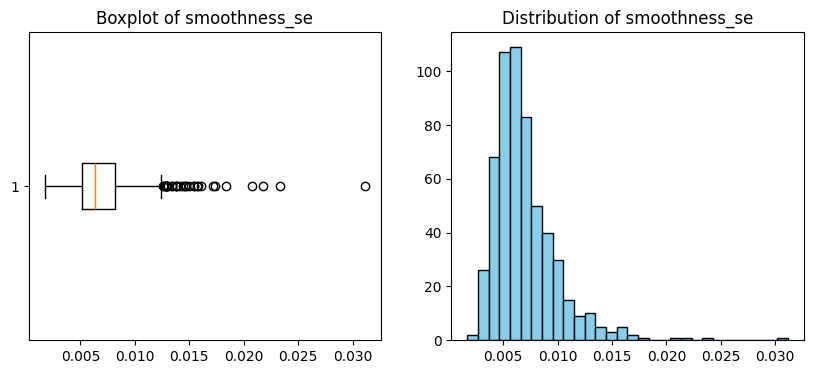

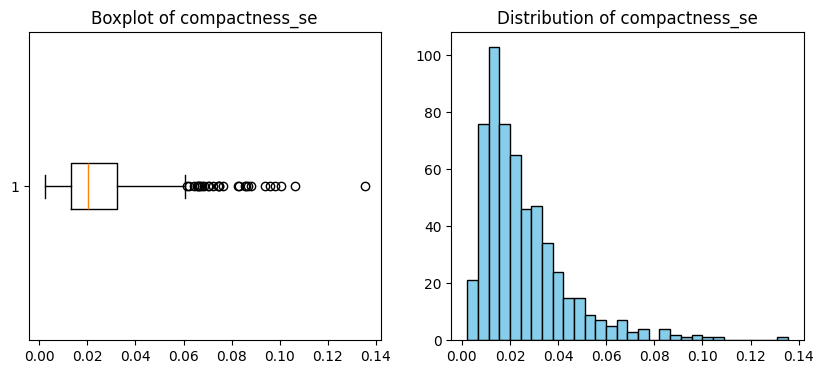

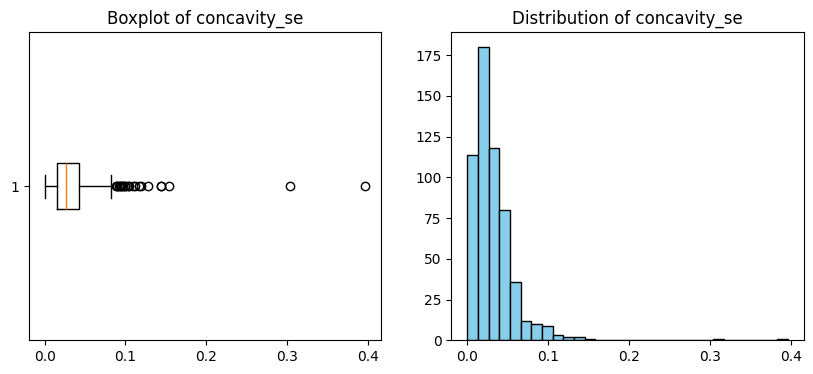

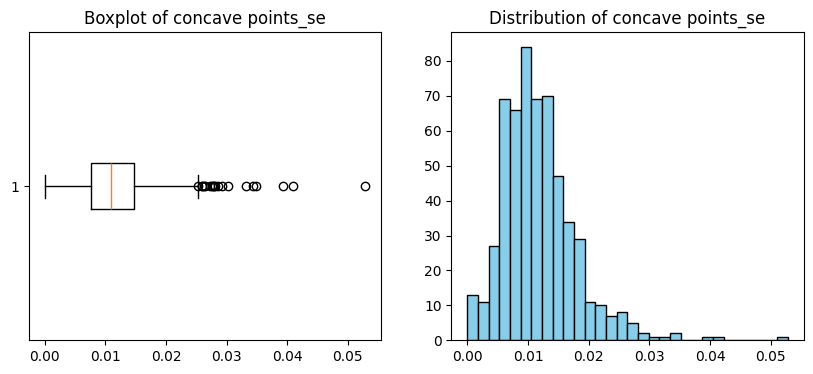

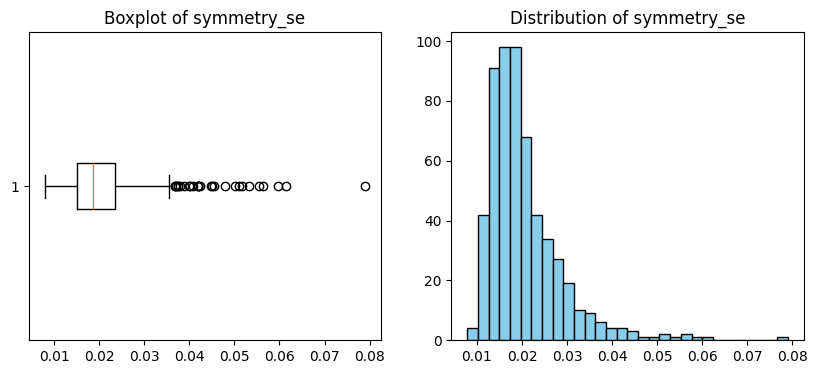

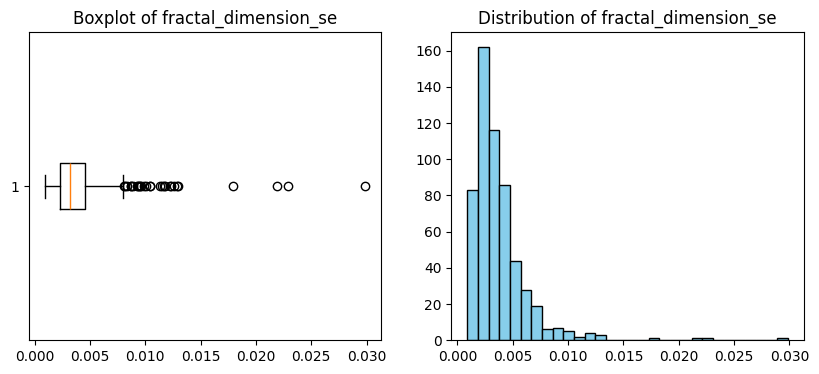

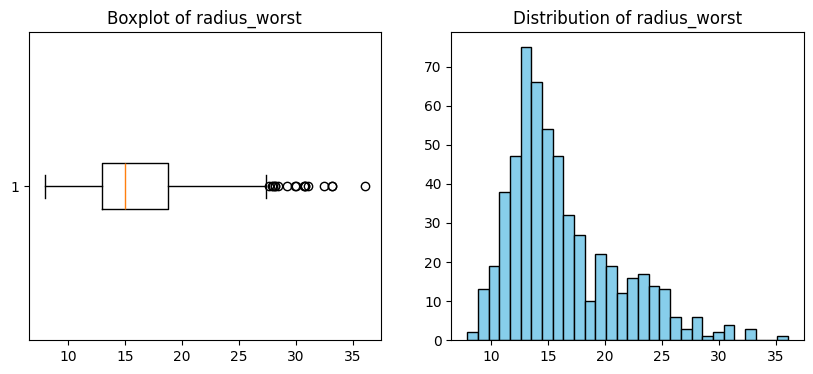

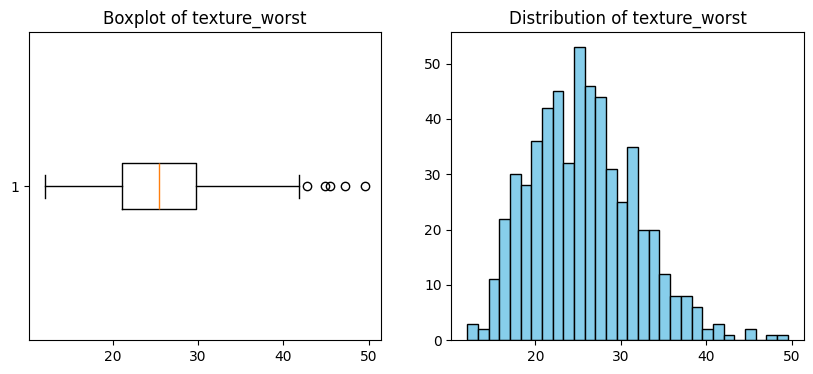

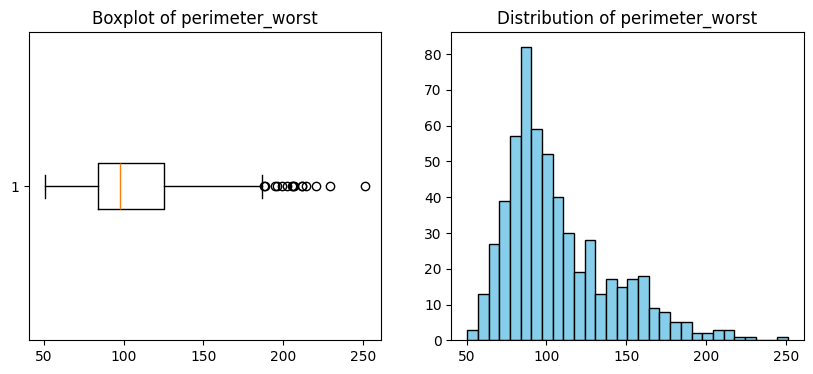

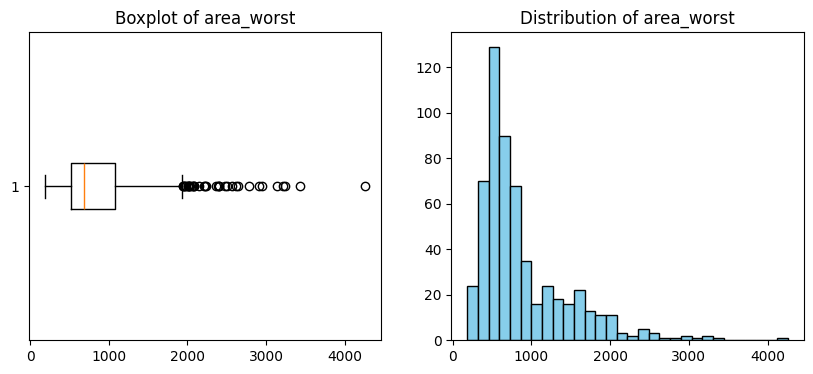

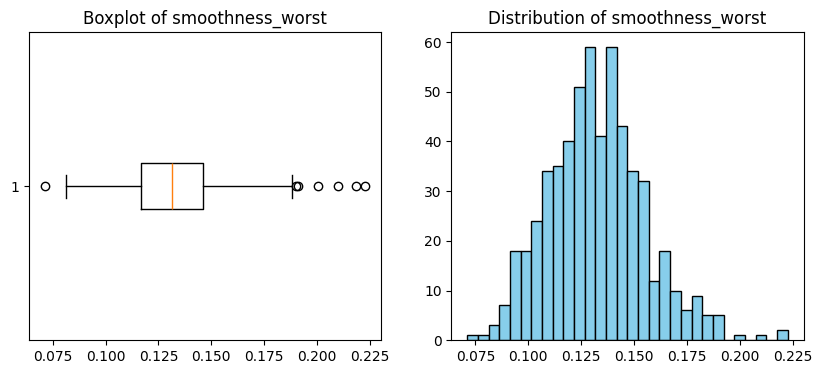

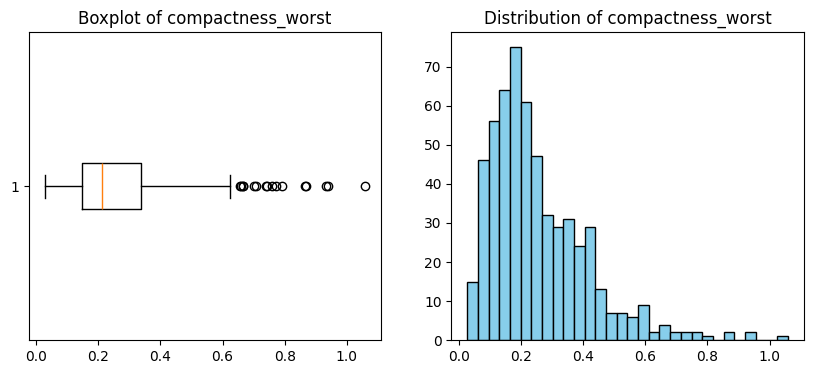

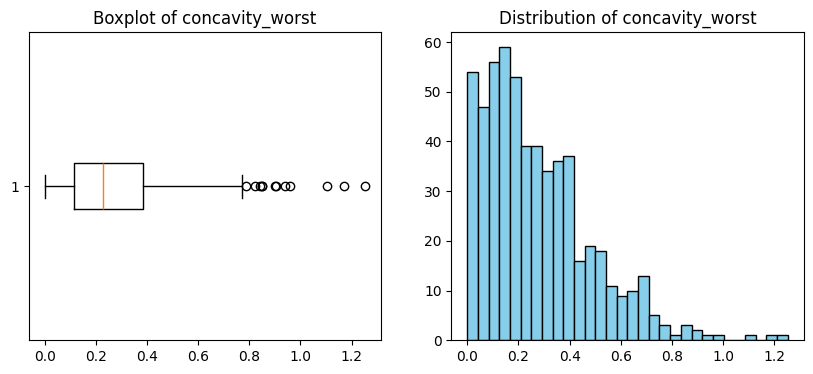

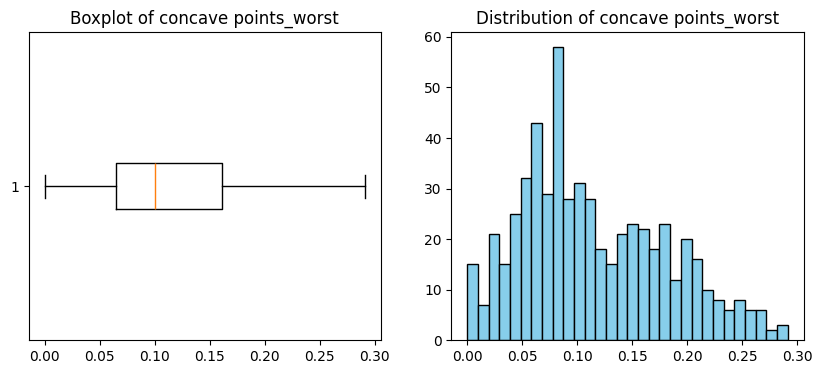

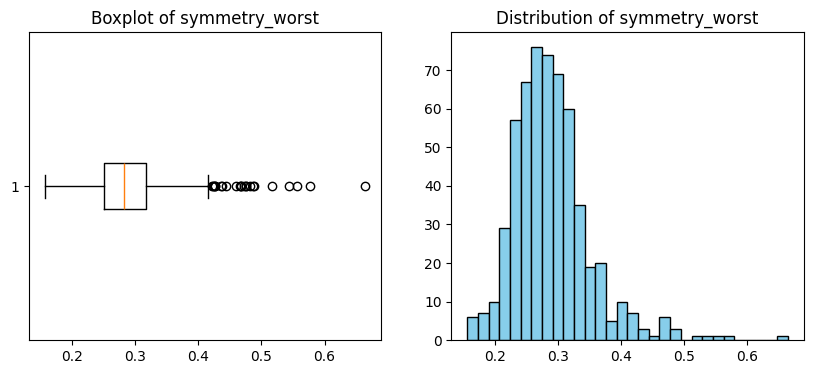

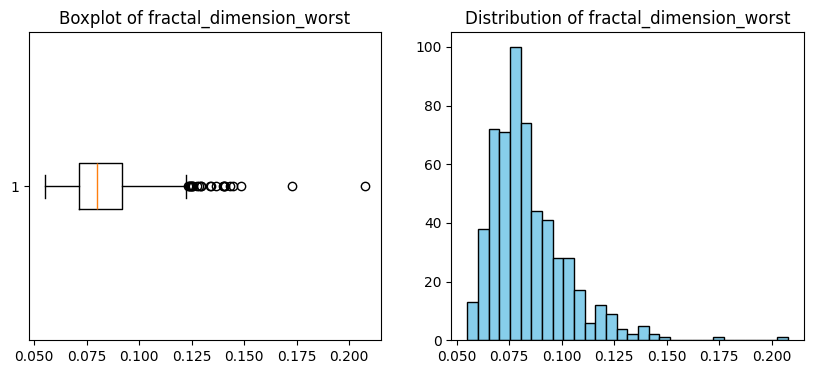


Summary of detected outliers per column:
- radius_mean: 14 outliers detected
- texture_mean: 7 outliers detected
- perimeter_mean: 0 outliers detected
- area_mean: 10 outliers detected
- smoothness_mean: 5 outliers detected
- compactness_mean: 11 outliers detected
- concavity_mean: 3 outliers detected
- concave points_mean: 0 outliers detected
- symmetry_mean: 9 outliers detected
- fractal_dimension_mean: 8 outliers detected
- radius_se: 16 outliers detected
- texture_se: 15 outliers detected
- perimeter_se: 3 outliers detected
- area_se: 19 outliers detected
- smoothness_se: 17 outliers detected
- compactness_se: 5 outliers detected
- concavity_se: 1 outliers detected
- concave points_se: 0 outliers detected
- symmetry_se: 6 outliers detected
- fractal_dimension_se: 4 outliers detected
- radius_worst: 0 outliers detected
- texture_worst: 0 outliers detected
- perimeter_worst: 0 outliers detected
- area_worst: 2 outliers detected
- smoothness_worst: 2 outliers detected
- compactness_w

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis
0,1.964461,0.377377,1.973596,2.108920,0.112751,0.650915,1.066356,1.488638,0.277054,-0.756789,...,0.521788,2.468580,2.665355,0.767070,0.428375,1.121869,1.941020,0.625692,0.333092,1
1,0.134540,0.594978,0.225722,0.033027,2.126689,2.239566,0.677832,0.935739,2.210386,2.655183,...,0.607065,0.541116,0.511879,1.815139,1.456575,0.369659,1.187592,0.931552,2.854076,1
2,1.065623,1.211941,0.968866,1.020884,-0.930314,-0.560180,-0.560181,-0.104415,-1.002217,-0.846630,...,1.626840,1.138359,1.280326,-0.523241,-0.524523,-0.459405,0.068471,0.361226,0.400490,1
3,0.968887,-0.157666,1.022372,0.945414,0.317713,1.229127,0.797817,1.178389,0.507899,-0.077988,...,0.454277,1.712978,1.732891,0.539659,3.248023,1.244971,1.696556,2.302172,2.027655,1
4,0.997102,1.393701,1.028317,0.953051,-0.768502,0.399021,0.794553,0.693088,0.531946,-1.563363,...,0.521788,0.604460,0.449613,-0.770426,-0.177761,0.127537,0.311933,0.041568,-1.336598,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393,-0.200005,2.666028,-0.232055,-0.252683,-0.999188,-0.802056,0.030768,-0.487341,-0.819464,-0.824669,...,1.957290,-0.443429,-0.403273,-0.295829,-0.460376,0.207111,-0.629251,-0.963401,-0.570354,0
394,-1.243947,2.330666,-1.232624,-1.119248,-0.246554,-0.277086,-0.009227,-0.332998,-0.689613,0.011853,...,1.809831,-1.315312,-1.126464,0.480335,-0.376707,-0.091461,-0.101451,-1.299157,0.264892,0
395,0.489238,1.068580,0.593727,0.388818,-0.708756,1.337899,0.866381,0.056962,-1.358104,0.051783,...,0.452500,0.328462,0.015273,-1.289517,0.981521,1.038895,0.283880,-1.225566,0.041037,0
396,0.271583,2.212905,0.295874,0.134104,0.499441,0.753963,-0.322863,0.278903,-0.958933,0.099698,...,1.500701,0.070562,-0.066128,-0.226617,0.138322,-0.549861,0.169663,-1.243964,0.295382,0


In [83]:
# Ways to treat outliers: "remove", "keep", "median", "mean"
strategy = "remove"
numerical_cols = data.drop(["diagnosis"], axis=1).columns.tolist()
target_col = "diagnosis"
normalized_data = handle_outliers_and_normalize(
    data, numerical_cols, target_col, strategy
)
normalized_data

### Feature selection

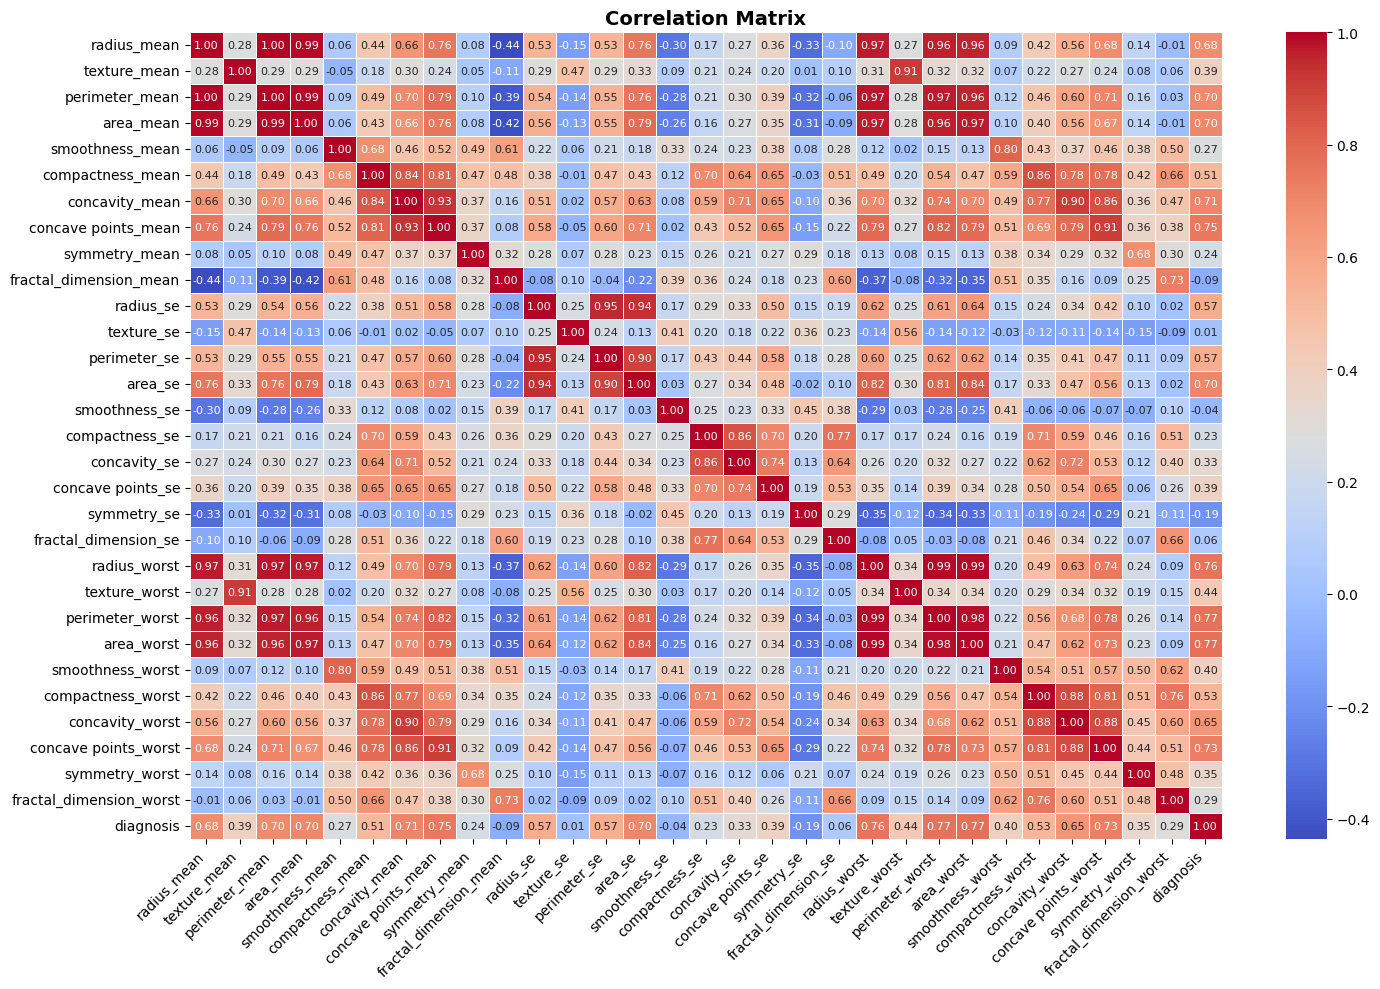

In [84]:
# Calculate the correlation matrix
corr_matrix = normalized_data.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.5,
    annot_kws={"size": 8},
)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.title("Correlation Matrix", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

Explained variance ratio by component:
[4.25290157e-01 1.87029171e-01 1.00377253e-01 6.38878533e-02
 6.31585595e-02 4.03607386e-02 2.71366446e-02 1.76653784e-02
 1.54743288e-02 1.13947256e-02 1.05053056e-02 9.36430756e-03
 7.81625475e-03 6.00182173e-03 3.56535285e-03 2.44509627e-03
 1.55372912e-03 1.37179296e-03 1.17232285e-03 9.55354290e-04
 7.71723292e-04 6.94847954e-04 5.33170875e-04 4.50766579e-04
 4.08338857e-04 2.96309304e-04 2.43820445e-04 5.24322779e-05
 1.92160199e-05 3.22619208e-06]


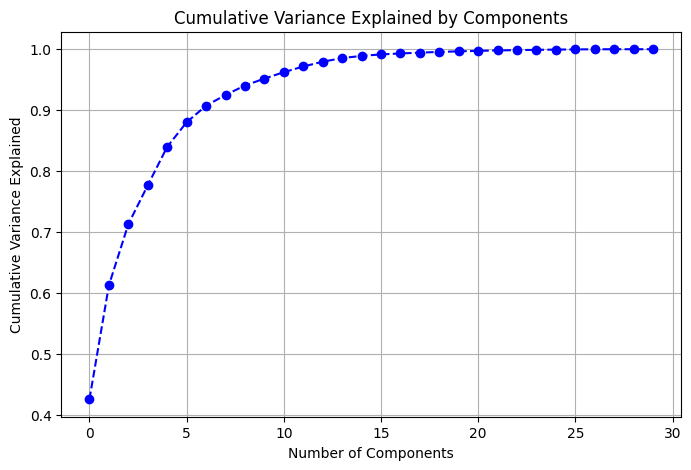

Optimal number of components to explain 95% of the variance: 10

First rows of the reduced dataset:
        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  5.927067 -3.505417 -1.262764  0.918328  0.253334 -0.212554  0.537035   
1  5.157012  4.175216  0.292621  1.952160  0.483912 -0.974573  2.663737   
2  1.173013 -3.408498  0.414729 -0.264824  1.803123  0.116081  1.676595   
3  6.369327  0.739285 -0.732368  0.143661 -0.210606  1.658567  1.718025   
4  2.786797 -0.666649  3.394382 -0.267920 -1.023933  1.203931 -2.657474   

        PC8       PC9      PC10  
0  0.289970  0.166103 -0.063746  
1 -0.756233 -0.267848  1.077529  
2  0.308689  0.787821 -0.138644  
3  1.021147 -0.201568 -0.475332  
4  1.050990  0.367212  0.048985  

Loadings of each component:


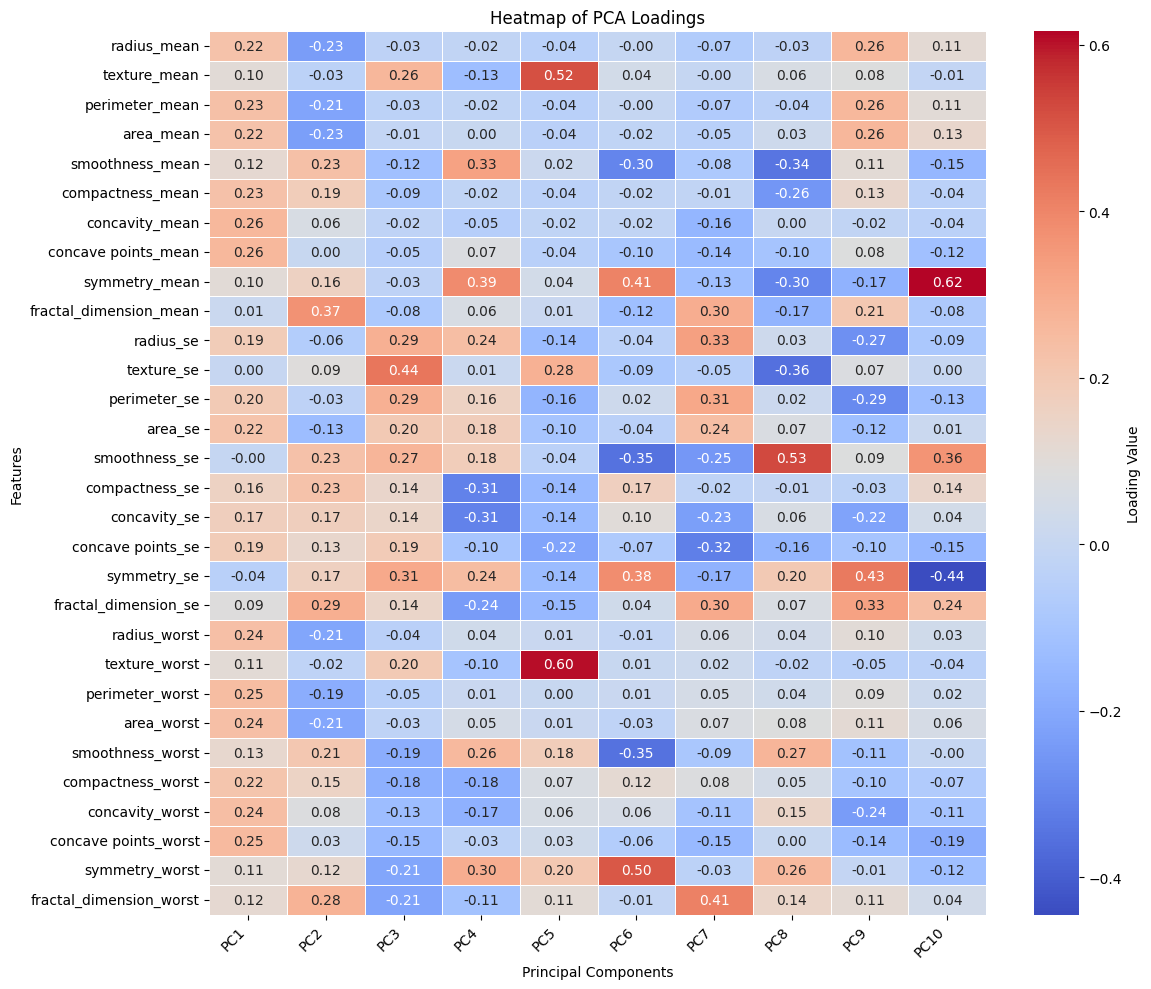

In [85]:
# Separate features (X) and target (y) from normalized data
target_col = "diagnosis"  # Define the target column
X_scaled = normalized_data.drop(columns=[target_col])  # Only features
y = normalized_data[target_col]  # Target variable

# Initialize PCA to analyze all components
pca = PCA(n_components=None)

# Fit PCA to the normalized feature data
X_pca = pca.fit_transform(X_scaled)

# Explained variance ratio for each component
explained_variance_ratio = pca.explained_variance_ratio_
print(f"Explained variance ratio by component:\n{explained_variance_ratio}")

# Visualize cumulative variance
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(explained_variance_ratio), marker="o", linestyle="--", color="b")
plt.title("Cumulative Variance Explained by Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Variance Explained")
plt.grid(True)
plt.show()

# Calculate cumulative variance
cumulative_variance = np.cumsum(explained_variance_ratio)

# Number of components to explain at least 95% of the variance
n_components = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Optimal number of components to explain 95% of the variance: {n_components}")

# Apply PCA with the optimal number of components
pca_opt = PCA(n_components=n_components)
X_reduced = pca_opt.fit_transform(X_scaled)

# Convert the reduced result to a DataFrame
X_reduced_df = pd.DataFrame(
    X_reduced, columns=[f"PC{i+1}" for i in range(n_components)]
)

print("\nFirst rows of the reduced dataset:")
print(X_reduced_df.head())

# Show the loadings (weights) of each component
loadings = pd.DataFrame(
    pca_opt.components_.T,  # Transpose to get the loadings
    index=X_scaled.columns,
    columns=[f"PC{i+1}" for i in range(n_components)],
)
print("\nLoadings of each component:")

# Plot heatmap of loadings to identify which variable has more influence in each component
plt.figure(figsize=(12, 10))
sns.heatmap(
    loadings,
    cmap="coolwarm",
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={"label": "Loading Value"},
)
plt.title("Heatmap of PCA Loadings")
plt.xlabel("Principal Components")
plt.ylabel("Features")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [86]:
# Extract Loadings from PC1
loadings_pc1 = loadings['PC1']
# Sort Loadings by Absolute Importance
top_features_pc1 = loadings_pc1.abs().sort_values(ascending=False)
# Select the N Most Important Features
n_features = 10
selected_features_pc1 = top_features_pc1.head(n_features).index.tolist()
print(f"Top {n_features} features based on PC1: {selected_features_pc1}")

# Number of Components for 95% Variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
k_components = np.argmax(cumulative_variance >= 0.95) + 1
# Sum Absolute Loadings of the First K Components
top_loadings = loadings.iloc[:, :k_components].abs().sum(axis=1)
# Select the N Most Important Features
n_features = 10
selected_features_k = top_loadings.sort_values(ascending=False).head(n_features).index.tolist()
print(f"Top {n_features} features based on top {k_components} components: {selected_features_k}")

Top 10 features based on PC1: ['concave points_mean', 'concavity_mean', 'concave points_worst', 'perimeter_worst', 'concavity_worst', 'radius_worst', 'area_worst', 'perimeter_mean', 'compactness_mean', 'area_mean']
Top 10 features based on top 10 components: ['symmetry_se', 'symmetry_mean', 'smoothness_se', 'fractal_dimension_se', 'symmetry_worst', 'smoothness_mean', 'smoothness_worst', 'radius_se', 'concave points_se', 'perimeter_se']


In [87]:
# y is defined in PCA
# Divide data for train and test set (80/20)
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

# if we want to use the top 10 features normalized_data[selected_features_k]\n",
# X_train, X_test, y_train, y_test = train_test_split(normalized_data[selected_features_k], y, test_size=0.5, random_state=42)


print(f"Training size: {X_train.shape}")
print(f"Test size: {X_test.shape}")

Training size: (318, 10)
Test size: (80, 10)


## Models

### KNN

Test accuracy with default KNN (k=5): 0.9625
Best k: 1


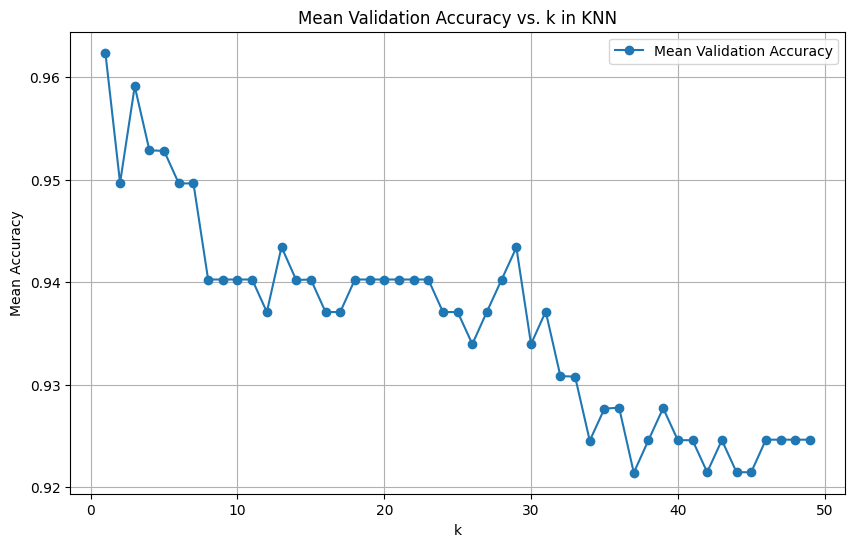

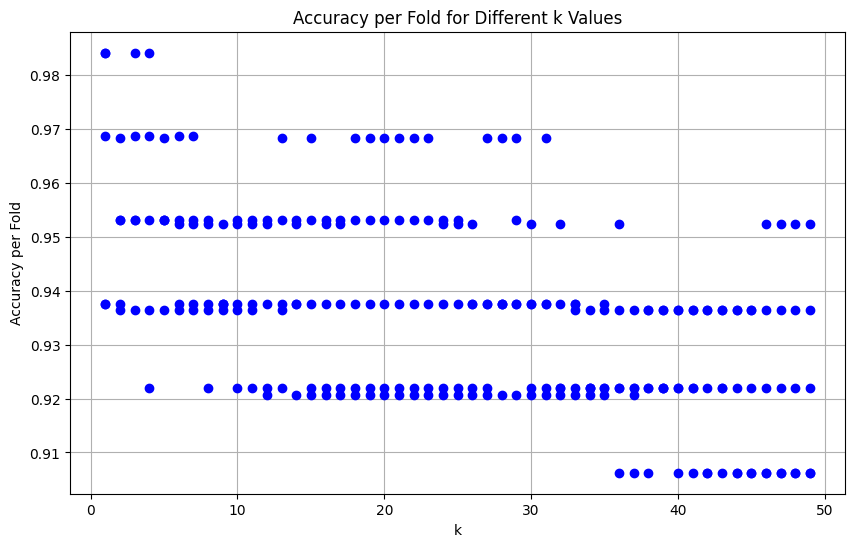

Test accuracy with k=1: 0.9625
Test accuracy with Weighted KNN and k=1: 0.9625


In [88]:
# Inicialization of KNN model with default values (k=5)
knn_default = KNeighborsClassifier()
knn_default.fit(X_train, y_train)
test_accuracy_default = knn_default.score(X_test, y_test)
print(f"Test accuracy with default KNN (k=5): {test_accuracy_default:.4f}")

# Variables to store results
k_values = range(1, 50)
cv_accuracies = []

# Store accuracies of each fold for analysis
all_folds_accuracies = {k: [] for k in k_values}
skf = KFold(n_splits=5, shuffle=True, random_state=42)

# Validation for different k values
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    fold_accuracies = cross_val_score(knn, X_train, y_train, cv=skf, scoring="accuracy")
    all_folds_accuracies[k] = fold_accuracies
    cv_accuracies.append(fold_accuracies.mean())

# Finding the best k value (with the best mean accuracy)
best_k = k_values[np.argmax(cv_accuracies)]
print(f"Best k: {best_k}")

# Graph the mean accuracy in cross-validation for different k values
plt.figure(figsize=(10, 6))
plt.plot(k_values, cv_accuracies, marker="o", label="Mean Validation Accuracy")
plt.xlabel("k")
plt.ylabel("Mean Accuracy")
plt.title("Mean Validation Accuracy vs. k in KNN")
plt.legend()
plt.grid(True)
plt.show()

# Graph the accuracy per fold for different k values
plt.figure(figsize=(10, 6))
for k in k_values:
    plt.plot(
        [k] * len(all_folds_accuracies[k]),
        all_folds_accuracies[k],
        "bo",
        label=f"k={k}" if k == 1 else "",
    )
plt.xlabel("k")
plt.ylabel("Accuracy per Fold")
plt.title("Accuracy per Fold for Different k Values")
plt.grid(True)
plt.show()

# Train the KNN model with the best k value and evaluate on the test set
best_knn = KNeighborsClassifier(n_neighbors=best_k)
best_knn.fit(X_train, y_train)
test_accuracy = best_knn.score(X_test, y_test)
print(f"Test accuracy with k={best_k}: {test_accuracy:.4f}")


# Improve with Weighted KNN
weighted_knn = KNeighborsClassifier(n_neighbors=best_k, weights="distance")
weighted_knn.fit(X_train, y_train)
weighted_test_accuracy = weighted_knn.score(X_test, y_test)
print(f"Test accuracy with Weighted KNN and k={best_k}: {weighted_test_accuracy:.4f}")

### Decision Tree

✅ Best max_depth: 1
📊 Best cross-validated accuracy: 0.9309


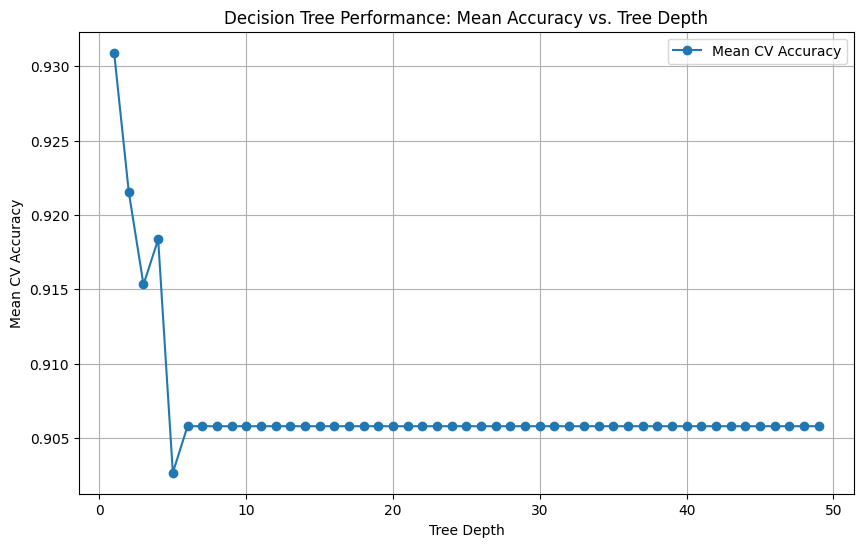

🎯 Test accuracy with max_depth=1: 0.9125


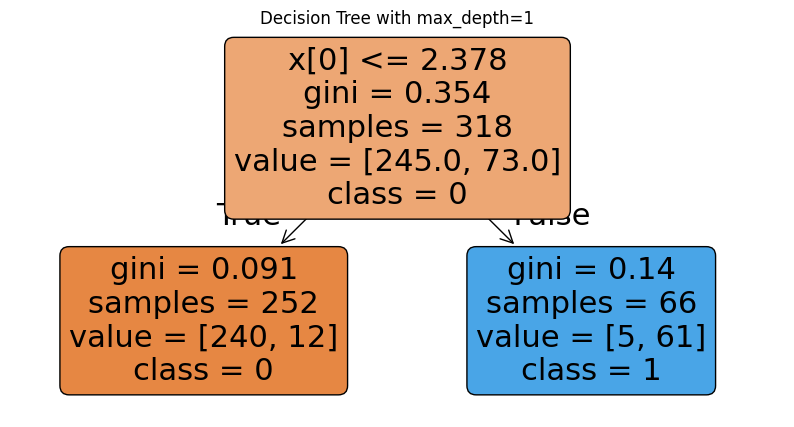

|--- feature_0 <= 2.38
|   |--- class: 0
|--- feature_0 >  2.38
|   |--- class: 1



In [89]:
# Initialize the Decision Tree Classifier
tree_clf = DecisionTreeClassifier(random_state=42)

# Set up KFold Cross-Validation
skf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the parameter grid for max_depth
param_grid = {"max_depth": np.arange(1, 50)}  # Test depths from 1 to 50

# Perform GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(
    tree_clf, param_grid, cv=skf, scoring="accuracy", return_train_score=True
)
grid_search.fit(X_train, y_train)  # Changed from train_X, train_Y to X_train, y_train

# Retrieve the best parameters and corresponding score
best_depth = grid_search.best_params_["max_depth"]
best_score = grid_search.best_score_

print(f"✅ Best max_depth: {best_depth}")
print(f"📊 Best cross-validated accuracy: {best_score:.4f}")

# Extract mean cross-validation scores for each max_depth
mean_test_scores = grid_search.cv_results_["mean_test_score"]

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(
    param_grid["max_depth"], mean_test_scores, marker="o", label="Mean CV Accuracy"
)
plt.xlabel("Tree Depth")
plt.ylabel("Mean CV Accuracy")
plt.title("Decision Tree Performance: Mean Accuracy vs. Tree Depth")
plt.grid(True)
plt.legend()
plt.show()

# Retrain Decision Tree with best depth
best_tree_clf = DecisionTreeClassifier(max_depth=best_depth, random_state=42)
best_tree_clf.fit(X_train, y_train)  # Changed from train_X, train_Y to X_train, y_train

# Evaluate on the test set
test_accuracy = accuracy_score(
    y_test, best_tree_clf.predict(X_test)
)  # Changed from test_Y, test_X to y_test, X_test
print(f"🎯 Test accuracy with max_depth={best_depth}: {test_accuracy:.4f}")

# Visualize decision tree
plt.figure(figsize=(10, 5))
plot_tree(
    best_tree_clf,
    class_names=[str(c) for c in best_tree_clf.classes_],
    filled=True,
    rounded=True,
)
plt.title(f"Decision Tree with max_depth={best_depth}")
plt.show()

# Print the tree rules (optional)
tree_rules = export_text(best_tree_clf)
print(tree_rules)

### Random Forest

Best Parameters: max_depth=7, n_estimators=50
Best Cross-Validated Accuracy: 0.9466


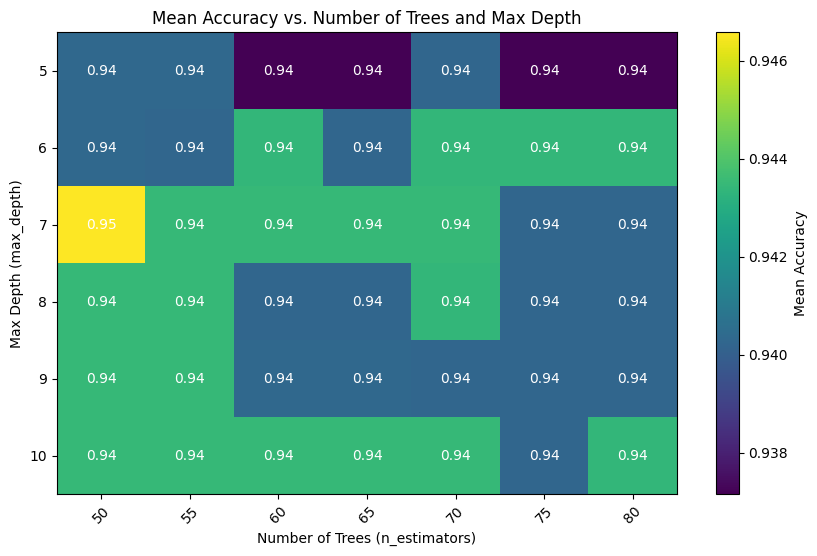

Test accuracy with best parameters: 0.9250


In [90]:
# Define the range of values for max_depth and n_estimators
max_depth_values = [5, 6, 7, 8, 9, 10]
n_estimators_values = [50, 55, 60, 65, 70, 75, 80]

# List to store results and an array to store mean accuracies for visualization
results = []
mean_accuracies = np.zeros((len(max_depth_values), len(n_estimators_values)))
skf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform grid search using cross-validation
for i, max_depth in enumerate(max_depth_values):
    for j, n_estimators in enumerate(n_estimators_values):
        # Initialize a RandomForest classifier with given max_depth and n_estimators
        rf_clf = RandomForestClassifier(
            max_depth=max_depth, n_estimators=n_estimators, random_state=42
        )

        # Perform 5-fold cross-validation and compute mean accuracy
        cv_scores = cross_val_score(
            rf_clf, X_train, y_train, cv=skf, scoring="accuracy"
        )
        mean_accuracy = np.mean(cv_scores)

        # Store the mean accuracy in the array for visualization
        mean_accuracies[i, j] = mean_accuracy

        # Append the result to the list
        results.append(
            {
                "max_depth": max_depth,
                "n_estimators": n_estimators,
                "mean_accuracy": mean_accuracy,
            }
        )

# Find the best combination of hyperparameters based on highest accuracy
best_result = max(results, key=lambda x: x["mean_accuracy"])
print(
    f"Best Parameters: max_depth={best_result['max_depth']}, n_estimators={best_result['n_estimators']}"
)
print(f"Best Cross-Validated Accuracy: {best_result['mean_accuracy']:.4f}")

plt.figure(figsize=(10, 6))
cax = plt.imshow(
    mean_accuracies, interpolation="nearest", cmap="viridis", aspect="auto"
)
plt.colorbar(cax, label="Mean Accuracy")
plt.xticks(np.arange(len(n_estimators_values)), n_estimators_values, rotation=45)
plt.yticks(np.arange(len(max_depth_values)), max_depth_values)
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("Max Depth (max_depth)")
plt.title("Mean Accuracy vs. Number of Trees and Max Depth")

for i in range(len(max_depth_values)):
    for j in range(len(n_estimators_values)):
        plt.text(
            j,
            i,
            f"{mean_accuracies[i, j]:.2f}",
            ha="center",
            va="center",
            color="white",
            fontsize=10,
        )

plt.grid(False)
plt.show()

# Train the best RandomForest model with optimal parameters
best_rf_clf = RandomForestClassifier(
    max_depth=best_result["max_depth"],
    n_estimators=best_result["n_estimators"],
    random_state=42,
)
best_rf_clf.fit(X_train, y_train)

# Evaluate the model on the test set
test_accuracy = accuracy_score(y_test, best_rf_clf.predict(X_test))
print(f"Test accuracy with best parameters: {test_accuracy:.4f}")

### Logistic Regression

Precision: 1.0
Recall: 0.88
Accuracy: 0.9625
F1: 0.9361702127659575


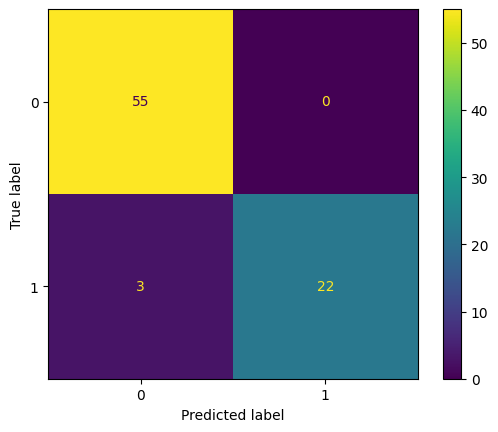

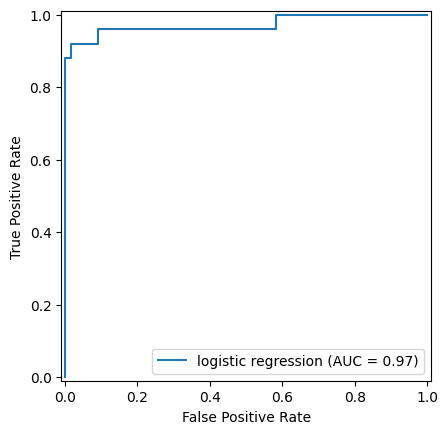

In [91]:
# Create a logistic regression model
model_diab = LogisticRegression()

# Fit the model with training data (X_train and y_train)
model_diab.fit(X_train, y_train)

# Predict values for the test data
predict = model_diab.predict(X_test)

# Create a confusion matrix to evaluate the model’s performance
matrix = metrics.confusion_matrix(y_test, predict)

# Visualize the confusion matrix
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot()

# Calculate and display the precision of the model
# Precision = TP / (TP + FP) -> How many predicted positives are actually positive
print("Precision:", metrics.precision_score(y_test, predict))

# Calculate and display the recall (sensitivity) of the model
# Recall = TP / (TP + FN) -> Ability of the model to capture all actual positives
print("Recall:", metrics.recall_score(y_test, predict))

# Calculate and display the accuracy of the model
# Accuracy = (TP + TN) / (Total) -> Proportion of correct predictions
print("Accuracy:", metrics.accuracy_score(y_test, predict))

# Calculate and display the F1-score
# F1 = 2 * (Precision * Recall) / (Precision + Recall) -> Harmonic mean of precision and recall
print("F1:", metrics.f1_score(y_test, predict))

# Get the prediction probabilities for the positive class
# predict_proba returns a matrix with 2 columns: [P(class 0), P(class 1)]
predict_prob = model_diab.predict_proba(X_test)

# Compute the ROC (Receiver Operating Characteristic) curve
# fpr: False Positive Rate
# tpr: True Positive Rate
# thresholds: Decision thresholds to classify positive/negative
fpr, tpr, thresholds = metrics.roc_curve(y_test, predict_prob[:, 1])

# Calculate the Area Under the ROC Curve (AUC)
# AUC measures the model's ability to distinguish between classes
roc_auc = metrics.auc(fpr, tpr)

# Plot the ROC curve
# Useful to assess model performance across different classification thresholds
display = metrics.RocCurveDisplay(
    fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name="logistic regression"
)
display.plot()

### Ridge and Lasso Regularization

Best Ridge C value: 0.615848
Best Ridge CV accuracy: 0.9654
Best Lasso C value: 0.233572
Best Lasso CV accuracy: 0.9717


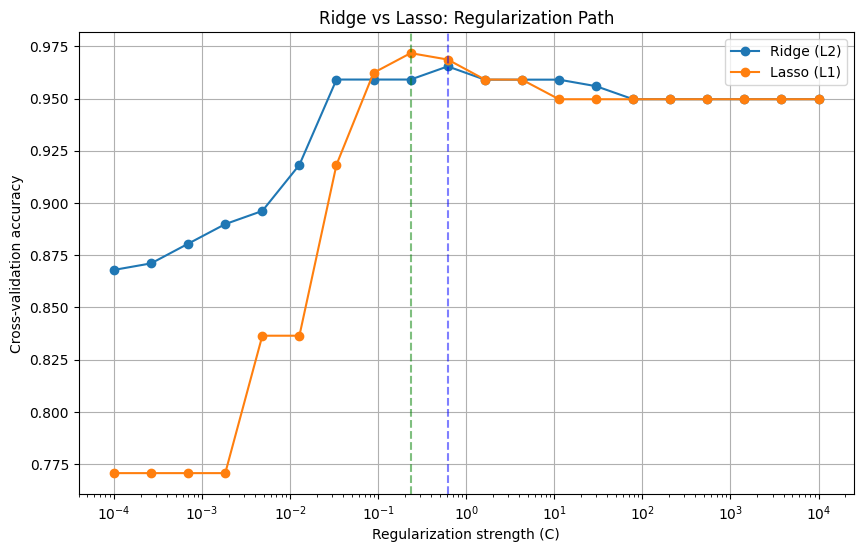

Ridge test accuracy: 0.9625
Lasso test accuracy: 0.9500


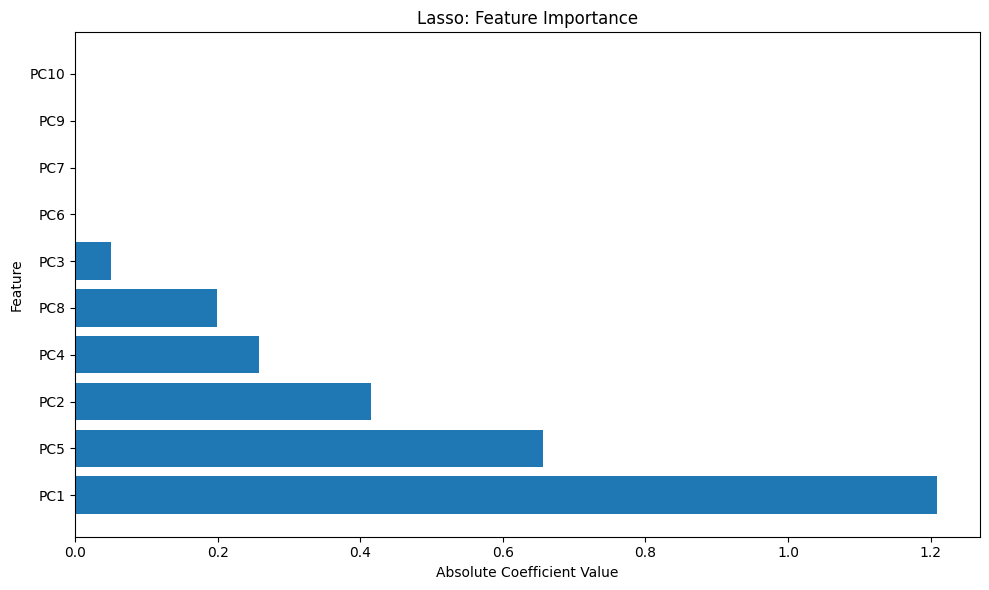

In [92]:
# Define parameter grid for regularization strength
C_values = np.logspace(-4, 4, 20)  # Wide range of regularization strengths

# Initialize KFold for cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Ridge regression
ridge_scores = []

for C in C_values:
    # Ridge uses l2 penalty (default)
    ridge_model = LogisticRegression(
        penalty="l2", C=C, solver="liblinear", random_state=42
    )
    cv_score = cross_val_score(
        ridge_model, X_train, y_train, cv=kfold, scoring="accuracy"
    )
    ridge_scores.append(np.mean(cv_score))

best_ridge_C = C_values[np.argmax(ridge_scores)]
print(f"Best Ridge C value: {best_ridge_C:.6f}")
print(f"Best Ridge CV accuracy: {max(ridge_scores):.4f}")

# Lasso regression
lasso_scores = []

for C in C_values:
    # Lasso uses l1 penalty
    lasso_model = LogisticRegression(
        penalty="l1", C=C, solver="liblinear", random_state=42
    )
    cv_score = cross_val_score(
        lasso_model, X_train, y_train, cv=kfold, scoring="accuracy"
    )
    lasso_scores.append(np.mean(cv_score))

best_lasso_C = C_values[np.argmax(lasso_scores)]
print(f"Best Lasso C value: {best_lasso_C:.6f}")
print(f"Best Lasso CV accuracy: {max(lasso_scores):.4f}")

# Plot regularization paths
plt.figure(figsize=(10, 6))
plt.semilogx(C_values, ridge_scores, marker="o", label="Ridge (L2)")
plt.semilogx(C_values, lasso_scores, marker="o", label="Lasso (L1)")
plt.axvline(x=best_ridge_C, color="blue", linestyle="--", alpha=0.5)
plt.axvline(x=best_lasso_C, color="green", linestyle="--", alpha=0.5)
plt.xlabel("Regularization strength (C)")
plt.ylabel("Cross-validation accuracy")
plt.title("Ridge vs Lasso: Regularization Path")
plt.legend()
plt.grid(True)
plt.show()

# Train final models with best parameters
best_ridge = LogisticRegression(
    penalty="l2", C=best_ridge_C, solver="liblinear", random_state=42
)
best_ridge.fit(X_train, y_train)
ridge_accuracy = accuracy_score(y_test, best_ridge.predict(X_test))
print(f"Ridge test accuracy: {ridge_accuracy:.4f}")

best_lasso = LogisticRegression(
    penalty="l1", C=best_lasso_C, solver="liblinear", random_state=42
)
best_lasso.fit(X_train, y_train)
lasso_accuracy = accuracy_score(y_test, best_lasso.predict(X_test))
print(f"Lasso test accuracy: {lasso_accuracy:.4f}")

# Feature importance for Lasso (coefficients indicate importance)
if hasattr(best_lasso, "coef_"):
    feature_names = [f"PC{i+1}" for i in range(X_train.shape[1])]
    coef_importance = pd.DataFrame(
        {"Feature": feature_names, "Coefficient": best_lasso.coef_[0]}
    )
    coef_importance = coef_importance.reindex(
        coef_importance["Coefficient"].abs().sort_values(ascending=False).index
    )

    plt.figure(figsize=(10, 6))
    plt.barh(coef_importance["Feature"], coef_importance["Coefficient"].abs())
    plt.xlabel("Absolute Coefficient Value")
    plt.ylabel("Feature")
    plt.title("Lasso: Feature Importance")
    plt.tight_layout()
    plt.show()

### Naive Bayes

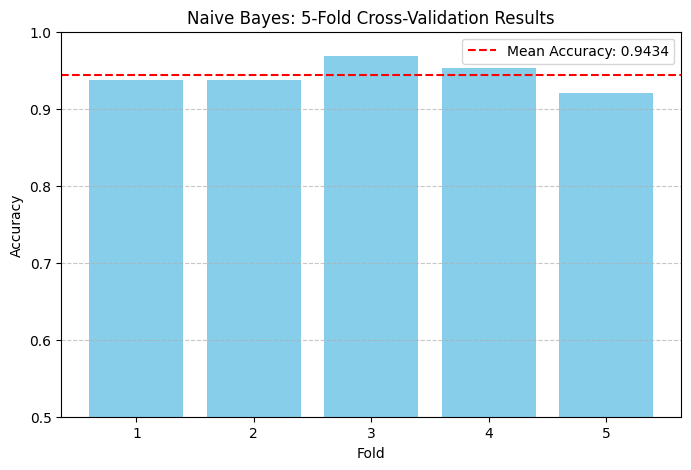

NAIVE BAYES MODEL EVALUATION

TRAINING DATA RESULTS:
Confusion Matrix:
 [[241   4]
 [ 13  60]]
Accuracy: 0.9465408805031447
F1-score for Malignant class: 0.8759124087591241
F1-score for Benign class: 0.9659318637274549

TEST DATA RESULTS:
Confusion Matrix:
 [[54  1]
 [ 5 20]]
Accuracy: 0.925
F1-score for Malignant class: 0.8695652173913043
F1-score for Benign class: 0.9473684210526315

Classification Report:
              precision    recall  f1-score   support

      Benign       0.92      0.98      0.95        55
   Malignant       0.95      0.80      0.87        25

    accuracy                           0.93        80
   macro avg       0.93      0.89      0.91        80
weighted avg       0.93      0.93      0.92        80



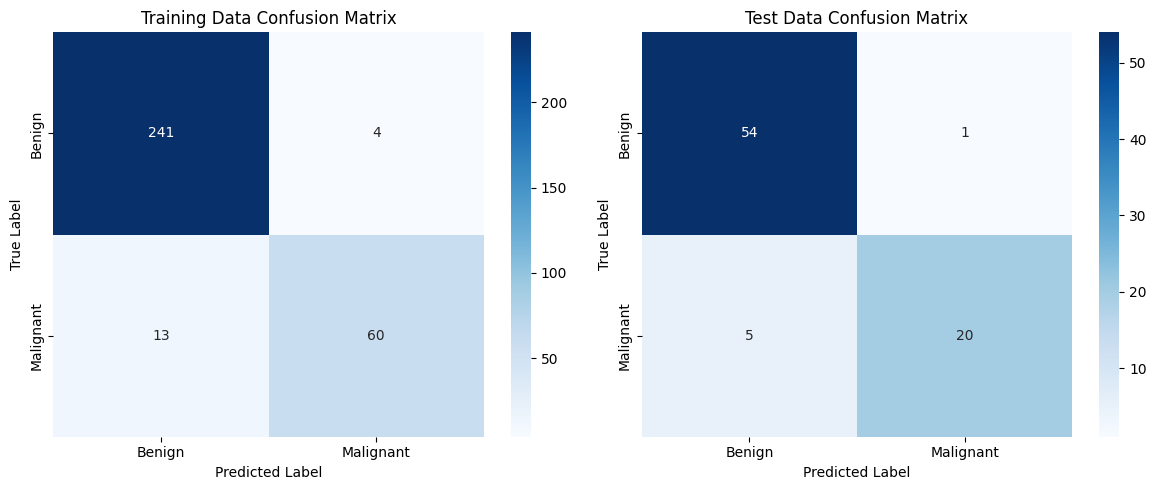

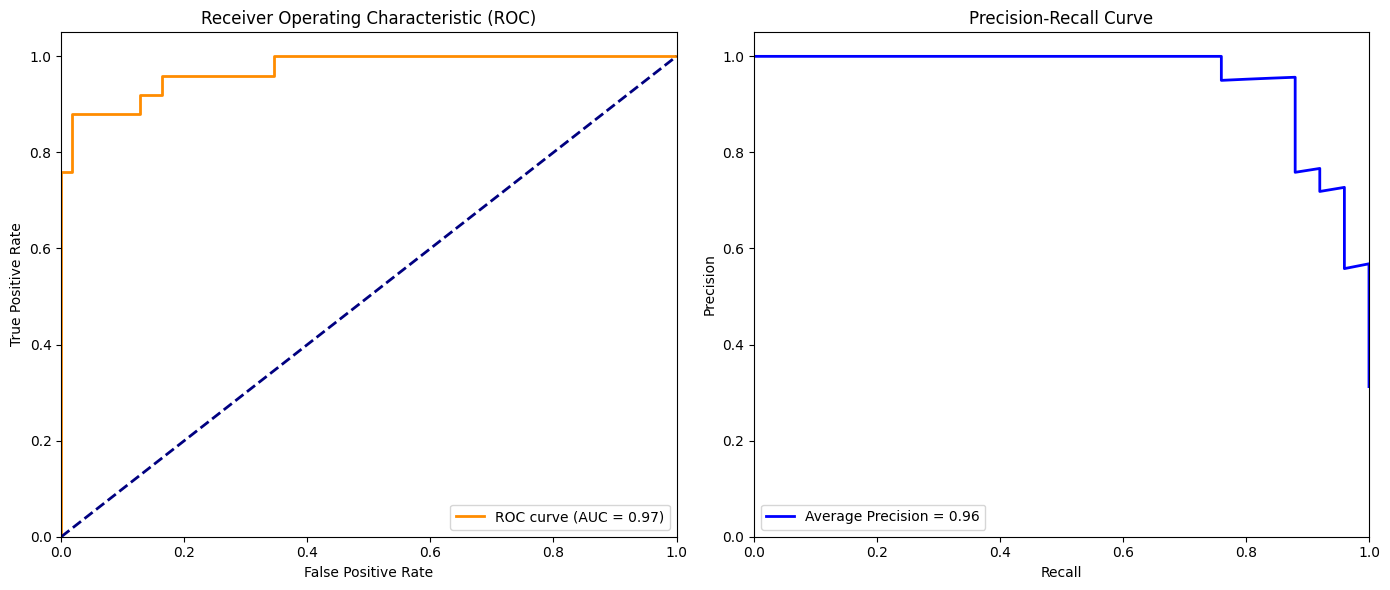

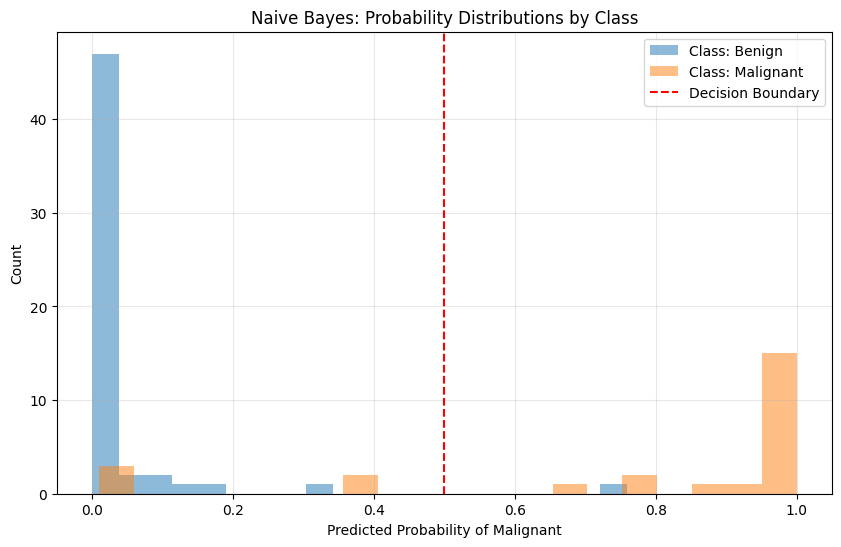


Naive Bayes Performance Summary:
Test Accuracy: 0.9250
AUC Score: 0.9724
Average Precision: 0.9570


In [93]:
# Initialize the Naive Bayes classifier
model_nb = GaussianNB()

# Train the model on the training data
model_nb.fit(X_train, y_train)

# Cross-validation for model stability assessment
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model_nb, X_train, y_train, cv=cv, scoring="accuracy")

# Plot cross-validation results
plt.figure(figsize=(8, 5))
plt.bar(range(1, len(cv_scores) + 1), cv_scores, color="skyblue")
plt.axhline(
    y=cv_scores.mean(),
    color="red",
    linestyle="--",
    label=f"Mean Accuracy: {cv_scores.mean():.4f}",
)
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.title("Naive Bayes: 5-Fold Cross-Validation Results")
plt.ylim(0.5, 1.0)
plt.xticks(range(1, len(cv_scores) + 1))
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Generate predictions
train_predictions = model_nb.predict(X_train)
test_predictions = model_nb.predict(X_test)
test_prob_predictions = model_nb.predict_proba(X_test)[:, 1]

# Evaluate on training data
print("NAIVE BAYES MODEL EVALUATION")
print("\nTRAINING DATA RESULTS:")
train_conf_matrix = confusion_matrix(y_train, train_predictions)
print("Confusion Matrix:\n", train_conf_matrix)
print("Accuracy:", accuracy_score(y_train, train_predictions))
print(
    "F1-score for Malignant class:", f1_score(y_train, train_predictions, pos_label=1)
)
print("F1-score for Benign class:", f1_score(y_train, train_predictions, pos_label=0))

# Evaluate on test data
print("\nTEST DATA RESULTS:")
test_conf_matrix = confusion_matrix(y_test, test_predictions)
print("Confusion Matrix:\n", test_conf_matrix)
print("Accuracy:", accuracy_score(y_test, test_predictions))
print("F1-score for Malignant class:", f1_score(y_test, test_predictions, pos_label=1))
print("F1-score for Benign class:", f1_score(y_test, test_predictions, pos_label=0))

# Detailed classification report
print("\nClassification Report:")
print(
    classification_report(
        y_test, test_predictions, target_names=["Benign", "Malignant"]
    )
)

# Visualize confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Training data confusion matrix
sns.heatmap(
    train_conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    ax=ax1,
    xticklabels=["Benign", "Malignant"],
    yticklabels=["Benign", "Malignant"],
)
ax1.set_xlabel("Predicted Label")
ax1.set_ylabel("True Label")
ax1.set_title("Training Data Confusion Matrix")

# Test data confusion matrix
sns.heatmap(
    test_conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    ax=ax2,
    xticklabels=["Benign", "Malignant"],
    yticklabels=["Benign", "Malignant"],
)
ax2.set_xlabel("Predicted Label")
ax2.set_ylabel("True Label")
ax2.set_title("Test Data Confusion Matrix")
plt.tight_layout()
plt.show()

# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, test_prob_predictions)
roc_auc = auc(fpr, tpr)

# Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, test_prob_predictions)
avg_precision = average_precision_score(y_test, test_prob_predictions)

# Visualize ROC and Precision-Recall curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# ROC curve
ax1.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
ax1.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel("False Positive Rate")
ax1.set_ylabel("True Positive Rate")
ax1.set_title("Receiver Operating Characteristic (ROC)")
ax1.legend(loc="lower right")

# Precision-Recall curve
ax2.plot(
    recall,
    precision,
    color="blue",
    lw=2,
    label=f"Average Precision = {avg_precision:.2f}",
)
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel("Recall")
ax2.set_ylabel("Precision")
ax2.set_title("Precision-Recall Curve")
ax2.legend(loc="lower left")

plt.tight_layout()
plt.show()

# Class probability distributions
plt.figure(figsize=(10, 6))
for i, label in enumerate(["Benign", "Malignant"]):
    mask = y_test == i
    class_samples = X_test[mask]
    if len(class_samples) > 0:
        # Get probability predictions for positive class
        class_probs = model_nb.predict_proba(class_samples)[:, 1]
        plt.hist(class_probs, bins=20, alpha=0.5, label=f"Class: {label}")

plt.axvline(x=0.5, color="red", linestyle="--", label="Decision Boundary")
plt.title("Naive Bayes: Probability Distributions by Class")
plt.xlabel("Predicted Probability of Malignant")
plt.ylabel("Count")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Performance summary
print("\nNaive Bayes Performance Summary:")
print(f"Test Accuracy: {accuracy_score(y_test, test_predictions):.4f}")
print(f"AUC Score: {roc_auc:.4f}")
print(f"Average Precision: {avg_precision:.4f}")

## Model Comparison

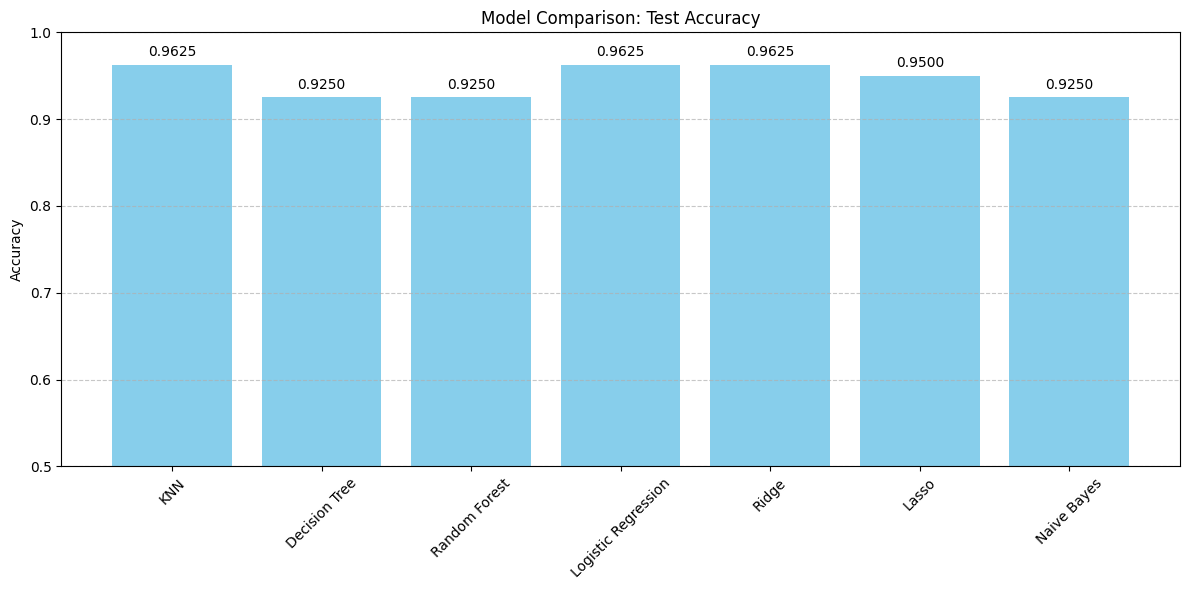

In [94]:
# Model comparison
models = ['KNN', 'Decision Tree', 'Random Forest', 'Logistic Regression', 'Ridge', 'Lasso', 'Naive Bayes']
accuracies = [
    weighted_test_accuracy, 
    test_accuracy,  # From Decision Tree
    test_accuracy,  # From Random Forest
    metrics.accuracy_score(y_test, predict),  # From Logistic Regression
    ridge_accuracy, 
    lasso_accuracy, 
    accuracy_score(y_test, test_predictions)  # From Naive Bayes
]

plt.figure(figsize=(12, 6))
plt.bar(models, accuracies, color='skyblue')
plt.title('Model Comparison: Test Accuracy')
plt.ylabel('Accuracy')
plt.ylim(0.5, 1.0)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
for i, v in enumerate(accuracies):
    plt.text(i, v+0.01, f"{v:.4f}", ha='center')
plt.tight_layout()
plt.show()